## Create a virtual env for the image classification project

## Install Dependencies and setup

In [ ]:
!conda install -c conda-forge tensorflow --yes

In [3]:
# Install the dependencies and setup
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [4]:
!pip list

Package                      Version
---------------------------- -------------
absl-py                      0.15.0
aiohttp                      3.8.3
aiosignal                    1.2.0
astor                        0.8.1
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.1.0
blinker                      1.4
brotlipy                     0.7.0
cachetools                   4.2.2
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           2.0.4
clang                        5.0
click                        8.0.4
colorama                     0.4.6
contourpy                    1.0.6
cryptography                 38.0.1
cycler                       0.11.0
dill                         0.3.6
dm-tree                      0.1.7
etils                        0.9.0
flatbuffers                  1.12
flit_core                    3.6.0
fonttools                    4.38.0
frozenlist                   1.3.3
gast 

In [4]:
import tensorflow as tf
import os
#os.path.join('Data','Images') creating a dir called data with the file Images
#os.listdir('Data') list out all the files in the dir

In [5]:
# limit the usage of our space memory
gpus = tf.config.experimental.list_physical_devices('CPU')

In [6]:
len(gpus)

1

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

# Remove dodge images

In [8]:
# some pics may have incorrect extensions
import cv2  #open image files
import imghdr # check extensions
from matplotlib import pyplot as plt

In [262]:
data_dir = 'data'

In [263]:
os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'happyfaces_pple'))

['happyfaces_pple', 'sadfaces_pple']

In [265]:
image_exts = ['jpeg','jpg','bmp','png']

In [12]:
image_exts[2]

'bmp'

In [264]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image data\sadfaces_pple\.ipynb_checkpoints


In [31]:
#tf.data.Dataset??

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [134]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [266]:
data = tf.keras.utils.image_dataset_from_directory('data',  batch_size = 5) # building our data pipeline

Found 170 files belonging to 2 classes.


In [233]:
data.classes

AttributeError: 'BatchDataset' object has no attribute 'classes'

In [269]:
# loop through our data pipeline
data_iterator = data.as_numpy_iterator()

In [270]:
# fetch data
batch = data_iterator.next()

In [271]:
batch[0].shape

(5, 256, 256, 3)

In [272]:
batch[1]

array([0, 0, 1, 1, 1])

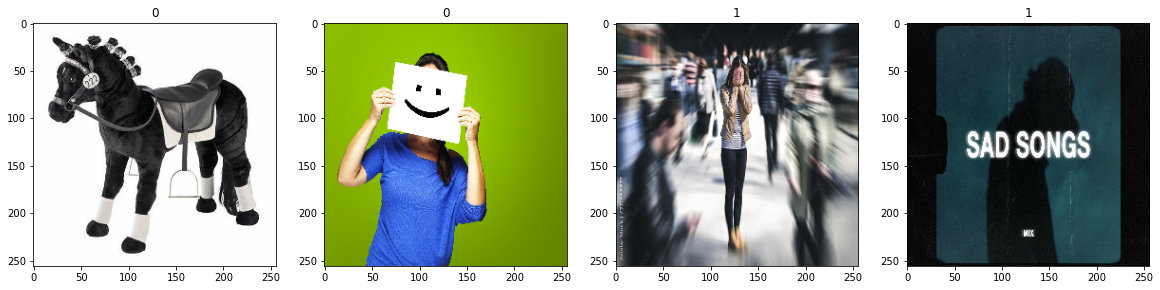

In [273]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# preprocessing step

In [274]:
batch[0].max()

255.0

In [275]:
data = data.map(lambda x,y: (x/255,y)) #x rep our images and y reps our labels

In [276]:
scaled_iterator = data.as_numpy_iterator()

In [277]:
batch = scaled_iterator.next()

In [278]:
batch[0].max()

1.0

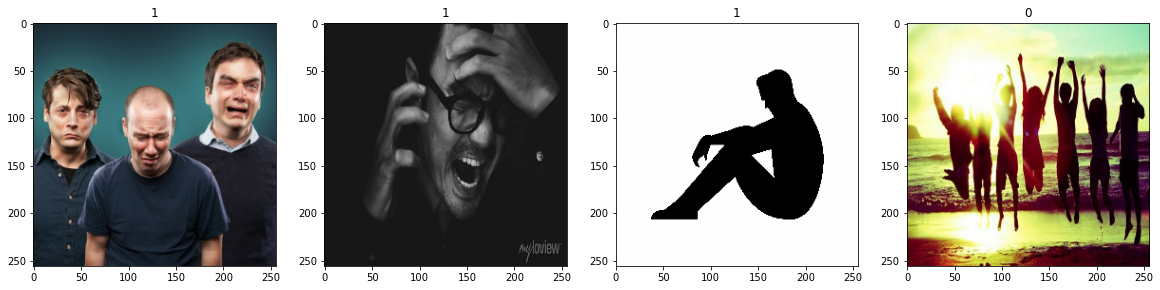

In [279]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Split data

In [280]:
len(data)

34

In [281]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [282]:
val_size+test_size+train_size

34

In [283]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Deep Learning Model

In [225]:
from tensorflow.keras.models import Sequential # models flow from input to output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [284]:
model = Sequential()

In [285]:
# adding a convolution layer
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3))) 
model.add(MaxPooling2D()) # take the max value,reduce img data

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) 

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) 

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [286]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics =['accuracy'])

In [287]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 64)      

# Train

In [156]:
logdir='logs'

In [157]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [254]:
fit??

Object `fit` not found.


In [288]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
23/23 [==============================] - 24s 705ms/step - loss: 1.1103 - accuracy: 0.5304 - val_loss: 0.8381 - val_accuracy: 0.3714
Epoch 2/20
23/23 [==============================] - 21s 686ms/step - loss: 0.6467 - accuracy: 0.6522 - val_loss: 0.5461 - val_accuracy: 0.6857
Epoch 3/20
23/23 [==============================] - 20s 655ms/step - loss: 0.5014 - accuracy: 0.7739 - val_loss: 0.4212 - val_accuracy: 0.8000
Epoch 4/20
23/23 [==============================] - 20s 652ms/step - loss: 0.3175 - accuracy: 0.8435 - val_loss: 0.4132 - val_accuracy: 0.8571
Epoch 5/20
23/23 [==============================] - 20s 660ms/step - loss: 0.2975 - accuracy: 0.8522 - val_loss: 0.2956 - val_accuracy: 0.8571
Epoch 6/20
23/23 [==============================] - 21s 659ms/step - loss: 0.1034 - accuracy: 0.9739 - val_loss: 0.2861 - val_accuracy: 0.9429
Epoch 7/20
23/23 [==============================] - 20s 656ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.2198 - val_accuracy: 0.9714

In [256]:
hist.history

{'loss': [-490538.90625,
  -9952477.0,
  -84956864.0,
  -417956128.0,
  -1518762752.0,
  -4628438528.0,
  -10752620544.0,
  -24777672704.0,
  -49592066048.0,
  -89410568192.0,
  -156928819200.0,
  -285748953088.0,
  -435162218496.0,
  -699398881280.0,
  -992228343808.0,
  -1437664542720.0,
  -1997556154368.0,
  -2594339028992.0,
  -3601562337280.0,
  -4724293107712.0],
 'accuracy': [0.47826087474823,
  0.48695650696754456,
  0.5043478012084961,
  0.47826087474823,
  0.48695650696754456,
  0.46086955070495605,
  0.5130434632301331,
  0.469565212726593,
  0.4521739184856415,
  0.4956521689891815,
  0.48695650696754456,
  0.4434782564640045,
  0.469565212726593,
  0.4521739184856415,
  0.469565212726593,
  0.4521739184856415,
  0.4434782564640045,
  0.48695650696754456,
  0.4521739184856415,
  0.46086955070495605],
 'val_loss': [-2021476.125,
  -30444618.0,
  -215274912.0,
  -483885792.0,
  -2933720320.0,
  -6226900992.0,
  -15181584384.0,
  -33350895616.0,
  -58907500544.0,
  -1159781580

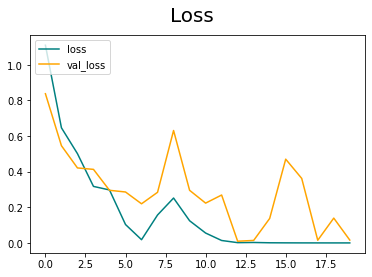

In [289]:
# plot performance
fig = plt.figure()
plt.plot(hist.history['loss'],color ='teal',label = 'loss')
plt.plot(hist.history['val_loss'], color= 'orange', label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

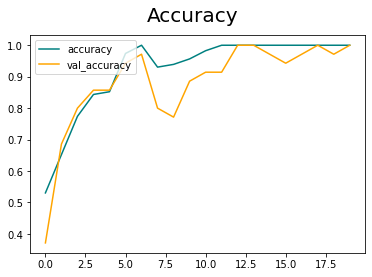

In [290]:
# plot performance
fig = plt.figure()
plt.plot(hist.history['accuracy'],color ='teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [112]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy



In [291]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [292]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 1s 1s/step


In [293]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall:0.875, Accuracy: 0.949999988079071


# Test

<function matplotlib.pyplot.show(close=None, block=None)>

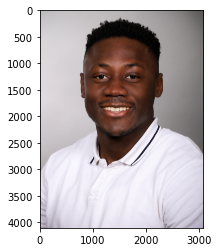

In [314]:
img = cv2.imread('tresorhappy.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

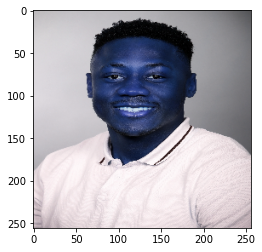

In [315]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [316]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [317]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 2s 2s/step


In [318]:
yhat

array([[1.]], dtype=float32)

In [313]:
if yhat <= 0.5:
    print(f'Predicted class is happy')
else:
    print(f'Predicted class is sad!!')

Predicted class is happy
